In [2]:
import sys
import os

# Get the current notebook's directory
notebook_dir = os.getcwd()  # current working directory

# Assume 'ml' folder is in the repo root, one level up from notebooks/
repo_root = os.path.abspath(os.path.join(notebook_dir, ".."))

# Add repo root to Python path if not already there
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

# Introduction/Motivation
TODO: Write an introduction
- What problems does Linear regression solve?
- Real-world examples where it is used
- Why understanding it deeply is important

# Dataset Loading
I'm now going to load a dataset for practice.
I'll start with a synthetic dataset so I can control its properties:
- Number of samples
- Noise level
I'm going to keep the number of features at 1 so I can visualize the results easily.
This allow us to test how the algorithm behaves with different inputs and visualize the results in 2D.

In [29]:
from data.load_data import load_synthetic_regression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(42)

def make_dataset(n_samples=100, n_features=1, noise=20, bias=10, random_state=42):
    X, y, true_bias = load_synthetic_regression(
        n_samples=n_samples,
        n_features=n_features,
        noise=noise,
        random_state=random_state,
        bias=bias
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    return X_train, X_test, y_train, y_test, true_bias

# Training the model

TODO: Fit the model
- Track loss per iteration
- Experiment: what happens if we increase/decrease lr or n_iters?

In [ ]:
import imageio
from ml.models.linear_model import LinearRegression

key = list(datasets_splits.keys())[15]
data = datasets_splits[key]
X_train, y_train, X_test, y_test = data["X_train"], data["y_train"], data["X_test"], data["y_test"]

frames = []

model = LinearRegression(lr=0.1, n_iters=1000)
model.fit(X_train, y_train, X_test, y_test)

for i, (W, b) in enumerate(model.params_history):
    if i % 10 == 0:
        y_pred_train = X_train.dot(W) + b
        y_pred_test = X_test.dot(W) + b
        loss_train = model.loss_history[i]
        loss_test = model.test_loss_history[i]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        
        # Top: scatter + line
        ax1.scatter(X_train, y_train, color='blue', label='Train')
        ax1.scatter(X_test, y_test, color='orange', label='Test')
        x_line = np.linspace(X_train.min(), X_train.max(), 100)
        y_line = W * x_line + b
        ax1.plot(x_line, y_line, color='red', label='Model')
        ax1.legend()
        ax1.set_title(f"Iteration {i}")
        
        # Bottom: loss curves
        ax2.plot(range(i+1), model.loss_history[:i+1], color='blue', label='Train Loss')
        ax2.plot(range(i+1), model.test_loss_history[:i+1], color='orange', label='Test Loss')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('MSE')
        ax2.legend()
        
        # Convert figure to image and append to frames
        fig.canvas.draw()  # Render the figure
        frame = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # RGBA
        frame = frame[:, :, :3] 
        frames.append(frame)
        plt.close(fig)  # close to save memory
    
imageio.mimsave('linear_regression_training_more_lr.gif', frames, duration=0.1)

The bias in linear regression is the intercept. If we keep the slope but change the bias, the regression will shift up or down, parallel to itself.

So, the effect of bias is vertical translation of the regression line.

In [ ]:
from ml.models.linear_model import LinearRegression  # your class
from ml.evaluation import mean_squared_error
import numpy as np

bias_values = [-30, 0, 30, 60]
colors = ["red", "green", "blue", "orange"]

plt.figure(figsize=(8,6))

for b, c in zip(bias_values, colors):
    X_train, X_test, y_train, y_test, true_bias = make_dataset(
        n_samples=100, noise=10, bias=b
    )
    model = LinearRegression(lr=0.01, n_iters=500)
    model.fit(X_train, y_train)

    # Line for plotting
    x_line = np.linspace(X_train.min(), X_train.max(), 100).reshape(-1, 1)
    y_line = model.predict(x_line)

    plt.plot(x_line, y_line, color=c, label=f"True bias={b}, Est={model.b:.1f}")

plt.xlabel("X")
plt.ylabel("y")
plt.title("Effect of Bias on Regression Line")
plt.legend()
plt.show()

Let's now check how noise affects the predictions.

Noise add random variation to the output. Predictions will still try to follow the trend, but with higher noise, the fitted line is less "clean" and MSE increases.

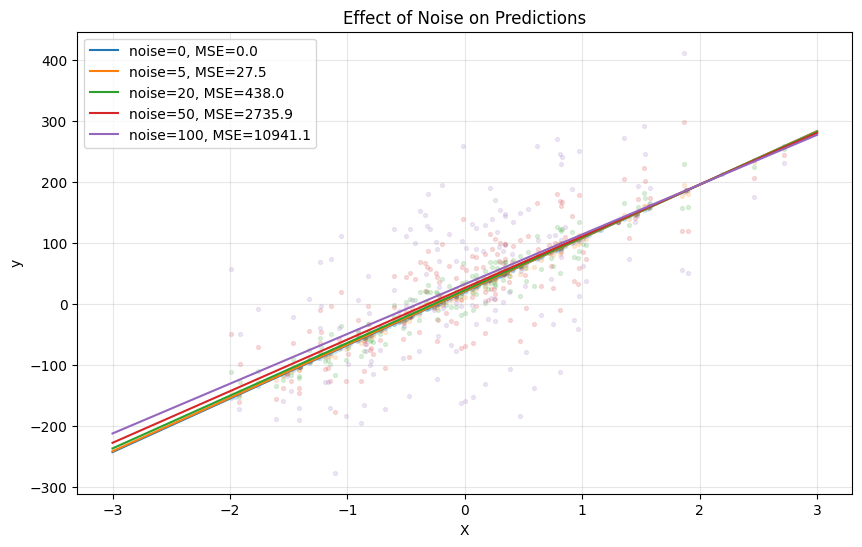

   noise   est_bias      test_mse
0      0  19.985838      0.018298
1      5  20.600709     27.476474
2     20  22.434736    438.032903
3     50  26.102789   2735.867532
4    100  32.216211  10941.063821


In [36]:
import pandas as pd

noise_levels = [0, 5, 20, 50, 100]
summary_rows = []

X_grid = np.linspace(-3, 3, 200).reshape(-1, 1)

plt.figure(figsize=(10, 6))
plt.title("Effect of Noise on Predictions")
plt.xlabel("X")
plt.ylabel("y")

for noise in noise_levels:
    X_train, X_test, y_train, y_test, true_bias = make_dataset(
        n_samples=200, n_features=1, noise=noise, bias=20, 
    )
    model = LinearRegression(lr=0.01, n_iters=800)
    model.fit(X_train, y_train, X_val=X_test, y_val=y_test)

    # Predictions
    y_grid_pred = model.predict(X_grid)
    y_test_pred = model.predict(X_test)

    # Metrics
    test_mse = mean_squared_error(y_test, y_test_pred)

    summary_rows.append({
        "noise": noise,
        "est_bias": float(model.b),
        "test_mse": float(test_mse)
    })

    # Plot one noisy scatter + line
    plt.scatter(X_train[:, 0], y_train, alpha=0.15, s=8)
    plt.plot(X_grid[:, 0], y_grid_pred, label=f"noise={noise}, MSE={test_mse:.1f}")

plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Summary table
df_summary = pd.DataFrame(summary_rows).sort_values("noise").reset_index(drop=True)
print(df_summary)


MSE is not the same as "accuracy of slope/bias". Even if our models capture the underlying trend perfectly, noisy data will always produce a higher MSE.

Linear regression estimates the expected value of y give x, not individual noisy points. Noise is random but with mean 0. So, even if noise is large, its expected value is 0. Over enough samples, the average effects of noise cancels out.

Let's try now with less points, and see if it still captures the trend.

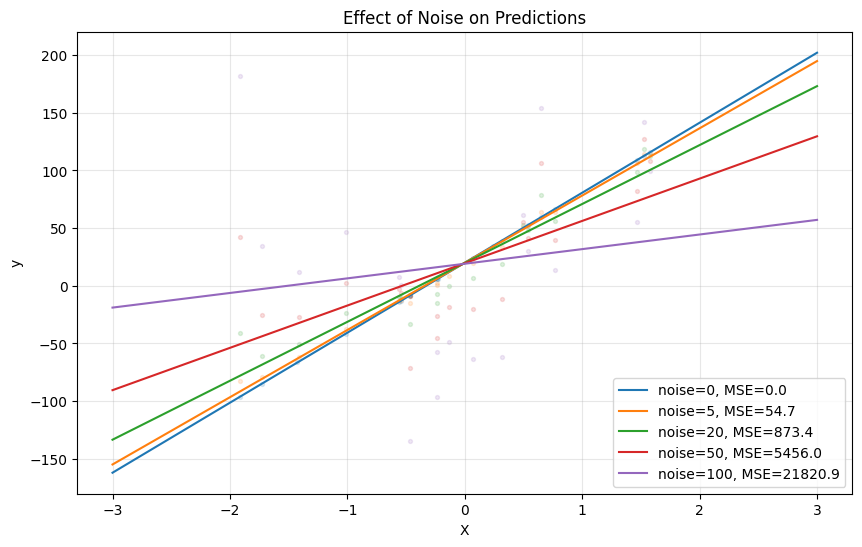

   noise   est_bias      test_mse
0      0  19.975704      0.000609
1      5  19.936099     54.706139
2     20  19.803084    873.354780
3     50  19.537052   5456.042550
4    100  19.093667  21820.938424


In [40]:
import pandas as pd

noise_levels = [0, 5, 20, 50, 100]
summary_rows = []

X_grid = np.linspace(-3, 3, 200).reshape(-1, 1)

plt.figure(figsize=(10, 6))
plt.title("Effect of Noise on Predictions")
plt.xlabel("X")
plt.ylabel("y")

for noise in noise_levels:
    X_train, X_test, y_train, y_test, true_bias = make_dataset(
        n_samples=25, n_features=1, noise=noise, bias=20, 
    )
    model = LinearRegression(lr=0.01, n_iters=800)
    model.fit(X_train, y_train, X_val=X_test, y_val=y_test)

    # Predictions
    y_grid_pred = model.predict(X_grid)
    y_test_pred = model.predict(X_test)

    # Metrics
    test_mse = mean_squared_error(y_test, y_test_pred)

    summary_rows.append({
        "noise": noise,
        "est_bias": float(model.b),
        "test_mse": float(test_mse)
    })

    # Plot one noisy scatter + line
    plt.scatter(X_train[:, 0], y_train, alpha=0.15, s=8)
    plt.plot(X_grid[:, 0], y_grid_pred, label=f"noise={noise}, MSE={test_mse:.1f}")

plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Summary table
df_summary = pd.DataFrame(summary_rows).sort_values("noise").reset_index(drop=True)
print(df_summary)


We can now see how, with each increase of noise, the estimated bias and slope deviate more from their true values.

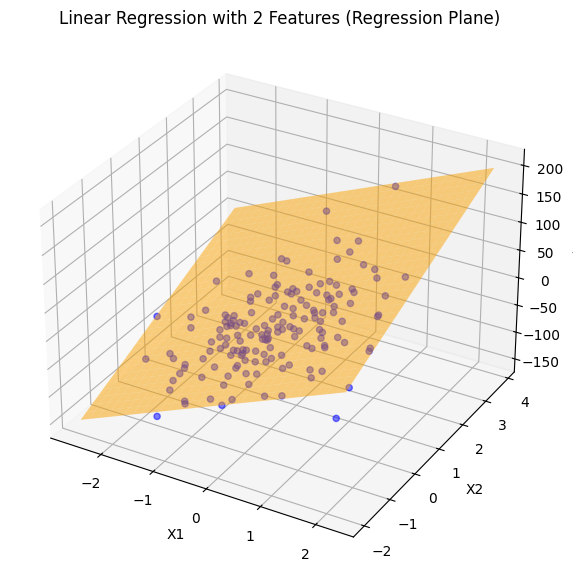

Estimated coefficients: [39.80128054 26.53482896]
Estimated bias: 8.163186823136755
Test MSE: 406.73058819678084


In [43]:
# Generate 2-feature dataset
X_train, X_test, y_train, y_test, true_bias = make_dataset(
    n_samples=200, n_features=2, noise=20, bias=10, random_state=42
)

# Fit your custom LinearRegression
model = LinearRegression(lr=0.01, n_iters=1000)
model.fit(X_train, y_train, X_val=X_test, y_val=y_test)

# Create grid for plane
x1_grid, x2_grid = np.meshgrid(
    np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 30),
    np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 30)
)
X_grid = np.column_stack((x1_grid.ravel(), x2_grid.ravel()))
y_grid = model.predict(X_grid).reshape(x1_grid.shape)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter data points
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color='blue', alpha=0.5, label='Data points')

# Regression plane
ax.plot_surface(x1_grid, x2_grid, y_grid, color='orange', alpha=0.5)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('y')
ax.set_title('Linear Regression with 2 Features (Regression Plane)')
plt.show()

# Print estimated coefficients
print("Estimated coefficients:", model.W)
print("Estimated bias:", model.b)

# Optional: test MSE
from ml.evaluation import mean_squared_error
y_test_pred = model.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, y_test_pred))



# Insights
- How weights relate to the slope of the line
- How bias affects predictions
- How the learning rate influences convergence
- How noise affects prediction accuracy
- What would happen with multiple features?